In [137]:
!pip install pyspark

## Problem Statement
Our client is ABC a leading firm and is doing well in the sector. It is recently facing a steep increase in its employee attrition . Employee attrition has gone up from 14% to 25% in the last 1 year . We are asked to prepare a strategy to immediately tackle this issue such that the firm’s business is not hampered and also to propose an efficient employee satisfaction program for long run. Currently, no such program is in place . Further salary hikes are not an option.



### Independent Variables were:
- Age: Age of employees,
- Department: Department of work,Distance from home,
- Education: 1-Below College; 2-College; 3-Bachelor; 4-Master; 5-Doctor;
- Education Field
- Environment Satisfaction: 1-Low; 2-Medium; 3-High; 4-Very High;
- Job Satisfaction: 1-Low; 2-Medium; 3-High; 4-Very High;
- Marital Status,
- Monthly Income,
- Num Companies Worked: Number of companies worked prior to IBM,
- Work Life Balance: 1-Bad; 2-Good; 3-Better; 4-Best;
- Years At Company: Current years of service in IBM
-Dependent Variable was:
- Attrition: Employee attrition status(0 or 1)

### LOAD DATASET

In [139]:
from pyspark.sql import SparkSession, Row
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import avg, col, stddev, corr ,sum , when, mean
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark import RDD
from pyspark.mllib.stat import Statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
spark = SparkSession.builder.appName("EmployeeAttritionAnalysis").getOrCreate()

# Read CSV files with a predefined schema
df = spark.read.csv('Attrition_Data.csv', header=True, inferSchema=True)
df.show(10)

+---+---------+--------------------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+
|Age|Attrition|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|WorkLifeBalance|YearsAtCompany|
+---+---------+--------------------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+
| 41|      Yes|               Sales|               1|        2| Life Sciences|                      2|              4|       Single|         5993|                 8|              1|             6|
| 49|       No|Research & Develo...|               8|        1| Life Sciences|                      3|              2|      Married|         5130|                 1|              3|            10|
| 37|      Yes|

In [141]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)



In [142]:
# Calculating the number of columns
len(df.columns)

13

In [143]:
# Counts the number of rows
df.count()

1470

In [144]:
# Counts the number of empty values ​​(null) in each column
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Displays the number of missing values ​​per column
missing_values.show()

+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+
|Age|Attrition|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|WorkLifeBalance|YearsAtCompany|
+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+
|  0|        0|         0|               0|        0|             0|                      0|              0|            0|            0|                 0|              0|             0|
+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+



In [145]:
# View duplicated data
df.groupBy(df.columns).count().filter("count > 1").show()

+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+-----+
|Age|Attrition|Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|WorkLifeBalance|YearsAtCompany|count|
+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+-----+
+---+---------+----------+----------------+---------+--------------+-----------------------+---------------+-------------+-------------+------------------+---------------+--------------+-----+



Observation:
- there are 13 columns and 1470 rows
- int and string data types
- no missing values
- no duplicated data

## Eksplorasi Dataset

In [146]:
# Displays the distribution of Attrition
df.groupBy("Attrition").count().show()
# Displays the distribution of Departments
df.groupBy("Department").count().show()
# Displays Maritalstatus distribution
df.groupBy("MaritalStatus").count().show()
# Displays the EducationField distribution
df.groupBy("EducationField").count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|               Sales|  446|
|Research & Develo...|  961|
|     Human Resources|   63|
+--------------------+-----+

+-------------+-----+
|MaritalStatus|count|
+-------------+-----+
|      Married|  673|
|     Divorced|  327|
|       Single|  470|
+-------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|Technical Degree|  132|
|           Other|   82|
|       Marketing|  159|
|         Medical|  464|
|   Life Sciences|  606|
| Human Resources|   27|
+----------------+-----+



Observation:
- The number of employees who left the company was 237 people and 1233 people were still working
- There are 3 departments, namely sales, research & development and human resources
- most of the employees are married followed by single and divorced
- employees have diverse education with the largest number in the Life Sciences field

In [147]:
# Calculates the correlation between MonthlyIncome and YearsAtCompany
correlation = df.stat.corr("MonthlyIncome", "YearsAtCompany")
print(f"Correlation between monthly income and years worked: {correlation}")

Correlation between monthly income and years worked: 0.5142848257331956


In [148]:
# Calculates the correlation between MonthlyIncome and Age
correlation = df.stat.corr("MonthlyIncome", "Age")
print(f"Correlation between monthly income and years of age: {correlation}")

Correlation between monthly income and years of age: 0.49785456692658


In [149]:
features = ['DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobSatisfaction',
                'MonthlyIncome', 'NumCompaniesWorked', 'WorkLifeBalance', 'YearsAtCompany']
assembler = VectorAssembler(inputCols=features, outputCol='features')
df_features = assembler.transform(df).select('features')

df_features.show(3)

+--------------------+
|            features|
+--------------------+
|[1.0,2.0,2.0,4.0,...|
|[8.0,1.0,3.0,2.0,...|
|[2.0,2.0,4.0,3.0,...|
+--------------------+
only showing top 3 rows



In [150]:
# Calculate the standard deviation for each feature in features
std_devs = df_features.rdd.map(lambda x: x[0]).stdev()

# Show standard deviation for each feature
print("Standar Deviasi Fitur:")
for i, std_dev in enumerate(std_devs):
  print(f"Fitur {features[i]}: {std_dev}")

Standar Deviasi Fitur:
Fitur DistanceFromHome: 8.104106529671775
Fitur Education: 1.02381652991026
Fitur EnvironmentSatisfaction: 1.092710354711113
Fitur JobSatisfaction: 1.1024709415085507
Fitur MonthlyIncome: 4706.355164823001
Fitur NumCompaniesWorked: 2.497159198593843
Fitur WorkLifeBalance: 0.7062354909319911
Fitur YearsAtCompany: 6.124440945793708


MonthlyIncome, YearsAtCompany, and DistanceFromHome show large variations, which can provide important insights in further analysis, especially regarding salary distribution, work experience, and residential distance. On the other hand, features such as Education and WorkLifeBalance show smaller variations, indicating uniformity among employees on these aspects.

## Transformasi Data


### RDD


**1.Do certain departments have higher attrition rates?**

In [151]:
# Retrieves Department and Attrition columns as RDD
rdd_department = df.select("Department", "Attrition").rdd

# Change 'Yes' to 1 and 'No' to 0
def convert_attrition(row):
    attrition_value = 1 if row["Attrition"] == "Yes" else 0
    return (row["Department"], (attrition_value, 1))

rdd_department_converted = rdd_department.map(convert_attrition)

# Looking at some data first
rdd_department.take(5)

[Row(Department='Sales', Attrition='Yes'),
 Row(Department='Research & Development', Attrition='No'),
 Row(Department='Research & Development', Attrition='Yes'),
 Row(Department='Research & Development', Attrition='No'),
 Row(Department='Research & Development', Attrition='No')]

In [152]:
# Calculate total employees and the number experiencing attrition per department
department_stats = rdd_department_converted.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate the attrition percentage per department
department_attrition_rate = department_stats.mapValues(lambda x: (x[0] / x[1]) * 100).sortBy(lambda x: x[1], ascending=False)

# See results
department_attrition_rate.collect()


[('Sales', 20.62780269058296),
 ('Human Resources', 19.047619047619047),
 ('Research & Development', 13.839750260145681)]

In [153]:
# Convert RDD to PySpark DataFrame
department_attrition_df = department_attrition_rate.map(lambda x: Row(department=x[0], attrition_rate=x[1])).toDF()
# Convert PySpark DataFrame to Pandas DataFrame
department_attrition_pd = department_attrition_df.toPandas()

<ipython-input-154-a6c7a921fb89>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='department', y='attrition_rate', data=department_attrition_pd, palette='viridis')


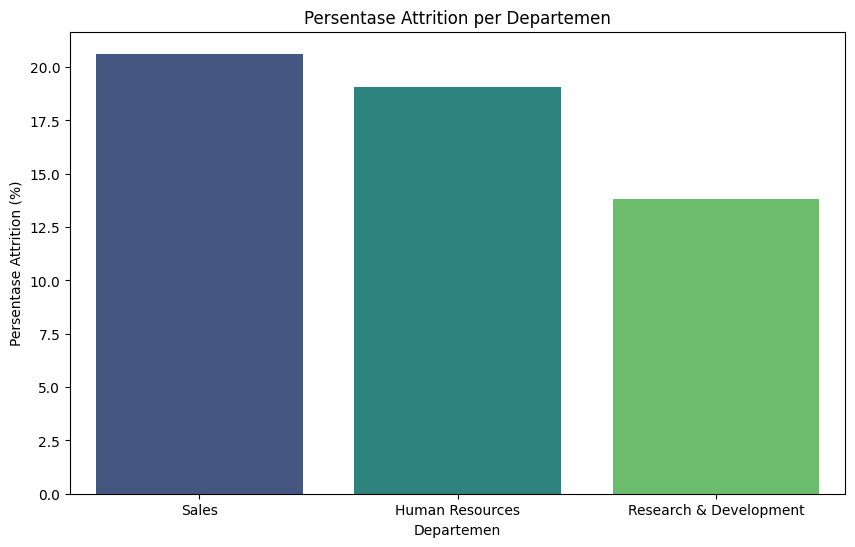

In [154]:
plt.figure(figsize=(10, 6))
sns.barplot(x='department', y='attrition_rate', data=department_attrition_pd, palette='viridis')
plt.xlabel('Departemen')
plt.ylabel('Persentase Attrition (%)')
plt.title('Persentase Attrition per Departemen')
plt.show()

The Sales Department has the highest attrition rate at around **20.63%,** followed by the Human Resources Department with **19.05%**. In contrast, the Research & Development Department has the lowest attrition rate, namely **13.84%**. This shows that employees in Sales and Human Resources are more likely to leave the company compared to employees in Research & Development.

### SQL

In [155]:
# Daftarkan DataFrame sebagai tabel SQL sementara
df.createOrReplaceTempView("employee")

**2. Do employees with low incomes have a significantly higher turnover rate compared to employees with medium or high incomes?**

In [156]:
income_attrition = spark.sql("""
SELECT
    CASE
        WHEN MonthlyIncome BETWEEN 1009 AND 7000 THEN 'Low Income'
        WHEN MonthlyIncome BETWEEN 7001 AND 13000 THEN 'Medium Income'
        WHEN MonthlyIncome BETWEEN 13001 AND 19999 THEN 'High Income'
    END AS income_group,
    COUNT(*) AS total_count,
    SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS attrition_rate
FROM employee
GROUP BY income_group
ORDER BY attrition_rate DESC
""")
income_attrition.show()


+-------------+-----------+---------------+--------------+
| income_group|total_count|attrition_count|attrition_rate|
+-------------+-----------+---------------+--------------+
|   Low Income|       1035|            190|         18.36|
|Medium Income|        250|             38|          15.2|
|  High Income|        185|              9|          4.86|
+-------------+-----------+---------------+--------------+



<ipython-input-157-cf352c0a8c48>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='income_group', y='attrition_rate', data=income_attrition_pd, palette='viridis')


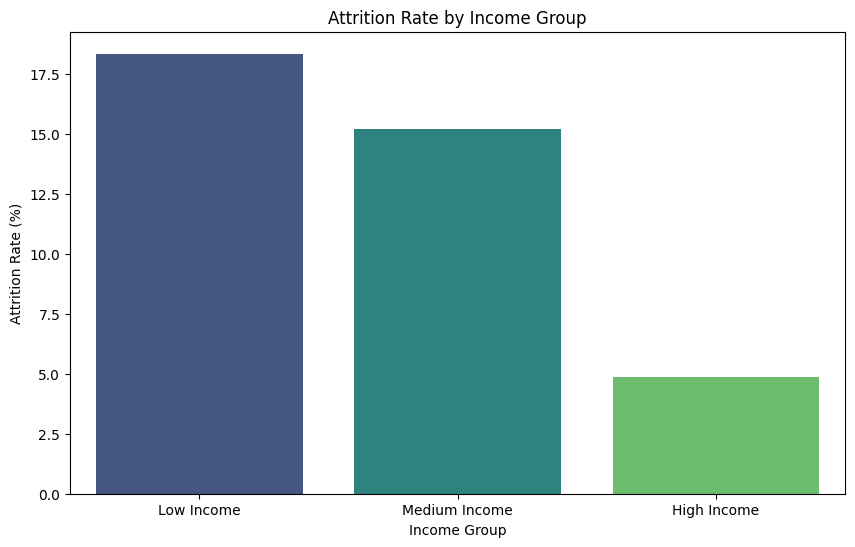

In [157]:
income_attrition_pd = income_attrition.toPandas()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='income_group', y='attrition_rate', data=income_attrition_pd, palette='viridis')
plt.title('Attrition Rate by Income Group')
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Income Group')
plt.show()

Employees with low incomes have significantly higher turnover rates than employees with medium or high incomes. The exit rate in the low income group **18.36%** was more than 3 times that of the medium income group **15.2%** and almost 4 times that of the high income group **4.86%**. This shows that employees with lower incomes tend to have a higher risk of leaving the company.


**3. What is the age distribution of employees in the company?**

In [165]:
age_group = spark.sql("""
SELECT
    CASE
        WHEN Age BETWEEN 18 AND 30 THEN 'Young'
        WHEN Age BETWEEN 31 AND 45 THEN 'Mature'
        WHEN Age BETWEEN 46 AND 60 THEN 'Old'
        ELSE 'Other'
    END AS age_group,
    COUNT(*) AS count_per_group
FROM employee
GROUP BY age_group
ORDER BY count_per_group DESC
""")

# Query execution
age_group.show()

+---------+---------------+
|age_group|count_per_group|
+---------+---------------+
|   Mature|            811|
|    Young|            386|
|      Old|            273|
+---------+---------------+



<ipython-input-166-7a366b8bfcfc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='count_per_group', data=age_groups_pd, palette='viridis')


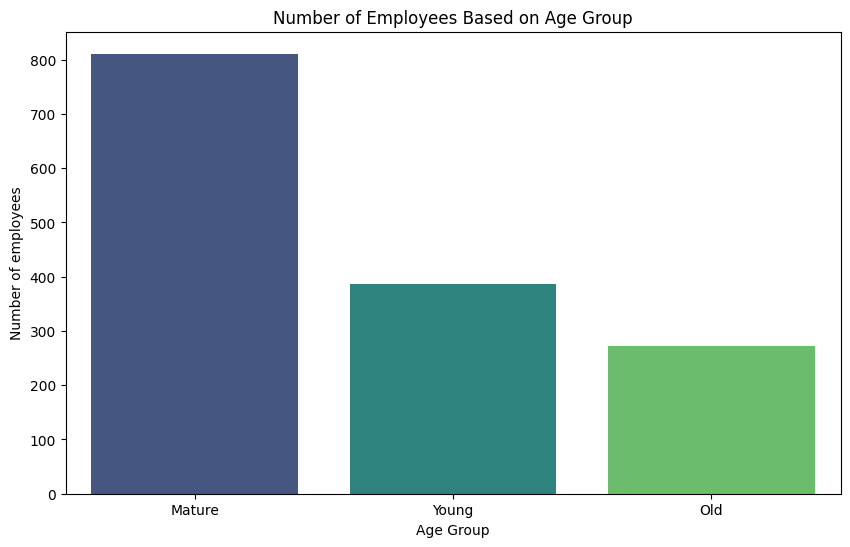

In [166]:
age_groups_pd = age_group.toPandas()

# Create a bar chart with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='count_per_group', data=age_groups_pd, palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Number of employees')
plt.title('Number of Employees Based on Age Group')
plt.show()


Most of **811** employees are in the mature age group of 31-45 years. The young age group 18-30 years has a significant number of employees **386** people, while the older age group 46-60 years has the least number of employees **273** people.

**3. Are employees with certain levels of education more likely to resign than others?**

In [160]:
Education_attrition = spark.sql("""
SELECT
    Education,
    COUNT(*) AS total_count,
    SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100,2) AS attrition_rate
FROM employee
GROUP BY Education
ORDER BY attrition_rate DESC
""")
Education_attrition.show()

+---------+-----------+---------------+--------------+
|Education|total_count|attrition_count|attrition_rate|
+---------+-----------+---------------+--------------+
|        1|        170|             31|         18.24|
|        3|        572|             99|         17.31|
|        2|        282|             44|          15.6|
|        4|        398|             58|         14.57|
|        5|         48|              5|         10.42|
+---------+-----------+---------------+--------------+



Data analysis shows that the level of education has a significant influence on employees' tendency to leave the company. Employees with less education 1 have a turnover rate of **18.24%**, well above average. In contrast, employees with the highest education 5 only have a turnover rate of **10.42%**. This trend shows that the higher an employee's education level, the less likely they are to leave the company. The difference in exit rates between secondary education groups 2 and 3 is relatively small.

**4. Is there a relationship between the level of work Environment Satisfaction and the level of employee resignation?**

In [161]:
EnvironmentSatisfaction_attrition = spark.sql("""
SELECT
    EnvironmentSatisfaction,
    COUNT(*) AS total_count,
    SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100,2) AS attrition_rate
FROM employee
GROUP BY EnvironmentSatisfaction
ORDER BY attrition_rate DESC
""")
EnvironmentSatisfaction_attrition.show()

+-----------------------+-----------+---------------+--------------+
|EnvironmentSatisfaction|total_count|attrition_count|attrition_rate|
+-----------------------+-----------+---------------+--------------+
|                      1|        284|             72|         25.35|
|                      2|        287|             43|         14.98|
|                      3|        453|             62|         13.69|
|                      4|        446|             60|         13.45|
+-----------------------+-----------+---------------+--------------+



Employees with a low work environment satisfaction level of 1 show a much higher tendency to resign, reaching 2**5.35%**, compared to other groups. On the other hand, employees who are very satisfied with the work environment 4 have the lowest resignation rate, namely **13.45%**. This shows that the higher the level of satisfaction with the work environment, the less likely employees are to leave the company. This significant difference confirms that a conducive and satisfying work environment is an important factor in retaining employees.

**5. Is marital status the main reason employees decide to leave work?**

In [162]:
MaritalStatus_attrition = spark.sql("""
SELECT
    MaritalStatus,
    COUNT(*) AS total_count,
    SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100,2) AS attrition_rate
FROM employee
GROUP BY MaritalStatus
ORDER BY attrition_rate DESC
""")
MaritalStatus_attrition.show()

+-------------+-----------+---------------+--------------+
|MaritalStatus|total_count|attrition_count|attrition_rate|
+-------------+-----------+---------------+--------------+
|       Single|        470|            120|         25.53|
|      Married|        673|             84|         12.48|
|     Divorced|        327|             33|         10.09|
+-------------+-----------+---------------+--------------+



Marital status has a significant influence on employee resignation rates. Unmarried employees have the highest resignation rate at **25.53%**, almost double that of divorced employees **10.09%**. Married employees show the middle resignation rate, namely **12.48%**. This shows that married employees tend to be more loyal to the company compared to employees who are unmarried or divorced.

**6. Do employees who have a good work-life balance resign less often?**

In [163]:
WorkLifeBalance_attrition = spark.sql("""
SELECT
    WorkLifeBalance,
    COUNT(*) AS total_count,
    SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS attrition_count,
    ROUND(SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*) * 100,2) AS attrition_rate
FROM employee
GROUP BY WorkLifeBalance
ORDER BY attrition_rate DESC
""")
WorkLifeBalance_attrition.show()

+---------------+-----------+---------------+--------------+
|WorkLifeBalance|total_count|attrition_count|attrition_rate|
+---------------+-----------+---------------+--------------+
|              1|         80|             25|         31.25|
|              4|        153|             27|         17.65|
|              2|        344|             58|         16.86|
|              3|        893|            127|         14.22|
+---------------+-----------+---------------+--------------+



Employees with a poor work-life balance 1 have the highest resignation rate, namely **31.25%**. On the other hand, employees who feel the best work-life balance 4 have the lowest resignation rate, namely **17.65%**. This suggests that the better the perceived work-life balance, the less likely employees are to leave the company.

## RECOMMENDATION
- Focus on improving working conditions in the Sales and Human Resources Department through satisfaction surveys and exit interviews.
- Improve facilities and create a more conducive work environment to reduce resignation rates.
- Provide training and career development for employees aged 31-45 years and with low levels of education.
- Terapkan kebijakan fleksibilitas kerja seperti jadwal fleksibel atau opsi kerja dari rumah.
- Design programs that support personal development and emotional well-being for single employees.
- Provide a clear career development path and offer mentoring or coaching without a salary increase.
- Improve internal communications and employee engagement through regular meetings and feedback sessions.